# TP n°8 : Banc MCC-MS

**Traitement des données et génération des figures avec méthode de Monte-Carlo**

Ce notebook génère les 4 figures du compte-rendu. 
Les incertitudes sur les paramètres des modèles sont estimées par **propagation de type Monte-Carlo** (1000 tirages) en supposant une distribution uniforme des erreurs dans l'intervalle d'incertitude constructeur.

In [449]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import os
from math import floor, log10

# Seed fixe pour reproductibilité
np.random.seed(42)

# --- Config graphique ---
ROUGE = '#B22133'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.family'] = 'serif'

# Créer le dossier figures s'il n'existe pas
os.makedirs('figures', exist_ok=True)
print("Configuration chargée (seed = 42).")

Configuration chargée (seed = 42).


## 1. Fonctions utilitaires et Monte-Carlo

Ici on définit tout ce qui concerne :
- Le calcul des incertitudes constructeur (à partir des fiches techniques des appareils)
- La conversion tachymètre -> vitesse angulaire
- L'algorithme Monte-Carlo pour propager les incertitudes à travers les fits

C'est le "coeur" du notebook, que l'on va réutiliser plusieurs fois pour chacune des questions.

In [450]:
# =============================================================================
# CONSTANTES DU MONTAGE
# =============================================================================

# Tachymètre : 0.06 V par tr/min
K_TACHY = 0.06  # V/(tr/min)
DELTA_K_REL = 0.01  # 1% d'incertitude relative sur cette constante

# Résolutions des appareils
RES_V = 0.1  # Voltmètre : 0.1 V
RES_W = 1.0  # Wattmètre/Pince puissance : 1 W
RES_I_PINCE = 0.01  # Pince ampèremétrique courant DC : 0.01 A

# Nombre de chiffres significatifs pour TOUTES les incertitudes (cohérence)
N_CS = 2


# =============================================================================
# FONCTIONS D'ARRONDI POUR LES INCERTITUDES
# =============================================================================

def arrondi_incertitude(u, n_chiffres=N_CS):
    """
    Arrondit une incertitude à n chiffres significatifs.
    Retourne (valeur arrondie, nombre de décimales).
    """
    if u == 0 or np.isnan(u) or np.isinf(u):
        return 0.0, 0
    exposant = floor(log10(abs(u)))
    decimales = -exposant + (n_chiffres - 1)
    decimales = max(0, int(decimales))
    u_arrondi = round(u, decimales)
    return u_arrondi, decimales

def arrondi_valeur_incertitude(val, u, n_chiffres=N_CS):
    """
    Arrondit une valeur et son incertitude de manière cohérente.
    L'incertitude est arrondie à n chiffres significatifs,
    la valeur est arrondie à la même décimale.
    """
    u_arr, dec = arrondi_incertitude(u, n_chiffres)
    val_arr = round(val, dec)
    return val_arr, u_arr, dec

def format_dynamique(val, dec):
    """Formate une valeur avec le bon nombre de décimales."""
    if dec == 0:
        return f"{val:.0f}"
    else:
        return f"{val:.{dec}f}"

def format_val_inc(val, u, n_chiffres=N_CS, unite=""):
    """
    Retourne une chaîne formatée "val ± u" avec arrondis cohérents.
    """
    val_arr, u_arr, dec = arrondi_valeur_incertitude(val, u, n_chiffres)
    return f"{format_dynamique(val_arr, dec)} ± {format_dynamique(u_arr, dec)}{unite}"


# =============================================================================
# FONCTIONS D'INCERTITUDE CONSTRUCTEUR
# =============================================================================
# Formule générale : Delta = sqrt( (precision * valeur)^2 + (nb_digits * resolution)^2 )
# "±(x%L + n digits)" dans la doc

def incertitude_tension(U):
    """
    Wattmètre en mode voltmètre : ±(1%L + 2 digits)
    Résolution 0.1 V donc 2 digits = 0.2 V
    """
    U = np.asarray(U, dtype=float)
    return np.sqrt((0.01 * np.abs(U))**2 + (2 * RES_V)**2)

def incertitude_puissance_pince(P):
    """
    Pince F205 en mode puissance DC : ±(2%L + 10 digits)
    Résolution 1 W donc 10 digits = 10 W
    """
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.02 * np.abs(P))**2 + (10 * RES_W)**2)

def incertitude_courant_pince(I):
    """
    Pince F205 en mode courant DC : ±(2%L + 10 digits)
    Résolution 0.01 A donc 10 digits = 0.1 A
    """
    I = np.asarray(I, dtype=float)
    return np.sqrt((0.02 * np.abs(I))**2 + (10 * RES_I_PINCE)**2)

def incertitude_puissance_wattmetre(P):
    """
    Wattmètre Metrix PX 120 : ±(1%L + 2 digits)
    Résolution 1 W donc 2 digits = 2 W
    """
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.01 * np.abs(P))**2 + (2 * RES_W)**2)


# =============================================================================
# CONVERSION TACHYMÈTRE
# =============================================================================

def convert_to_omega_rad(U_tachy):
    """
    Convertit la tension du tachymètre en vitesse angulaire.
    
    U_tachy [V] -> Omega [rad/s]
    
    Formule : Omega = (U / K) * (2*pi/60)
    où K = 0.06 V/(tr/min)
    """
    U_tachy = np.asarray(U_tachy, dtype=float)
    omega_rpm = U_tachy / K_TACHY  # d'abord en tr/min
    return omega_rpm * 2 * np.pi / 60  # puis en rad/s

def incertitude_omega(U_tachy):
    """
    Propagation de l'incertitude sur Omega.
    
    On combine :
    - l'incertitude sur U_tachy (du voltmètre)
    - l'incertitude sur K (1% donnée constructeur)
    """
    U_tachy = np.asarray(U_tachy, dtype=float)
    delta_U = incertitude_tension(U_tachy)
    omega = convert_to_omega_rad(U_tachy)
    
    # Propagation : (dOmega/Omega)^2 = (dU/U)^2 + (dK/K)^2
    delta_omega_rel = np.sqrt((delta_U / U_tachy)**2 + DELTA_K_REL**2)
    return omega * delta_omega_rel


# =============================================================================
# MODÈLES DE FIT
# =============================================================================

def modele_lineaire(x, a, b):
    """y = a*x + b"""
    return a * x + b

def modele_poly2(x, c2, c1, c0):
    """y = c2*x² + c1*x + c0 (attention à l'ordre des coeffs !)"""
    return c2 * x**2 + c1 * x + c0


# =============================================================================
# MONTE-CARLO
# =============================================================================

def monte_carlo_fit(func, x, y, dx, dy, p0=None, N=1000):
    """
    Réalise N ajustements en perturbant x et y selon une loi uniforme 
    dans l'intervalle [-delta, +delta].
    
    Paramètres:
        func : fonction modèle (ex: modele_lineaire)
        x, y : données
        dx, dy : incertitudes (barres d'erreur)
        p0 : guess initial pour curve_fit (optionnel)
        N : nombre de tirages (1000 par défaut, c'est un bon compromis)
    
    Output:
        popt_mean : paramètres moyens
        popt_std : écart-type des paramètres (= incertitude type, k=1)
        params_list : tous les paramètres (pour tracer les bandes de confiance)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dx = np.asarray(dx)
    dy = np.asarray(dy)
    
    params_list = []
    
    for i in range(N):
        # Tirage uniforme dans [-delta, +delta]
        xtemp = x + np.random.uniform(-dx, dx)
        ytemp = y + np.random.uniform(-dy, dy)
        
        try:
            popt, _ = curve_fit(func, xtemp, ytemp, p0=p0, maxfev=5000)
            params_list.append(popt)
        except RuntimeError:
            continue
            
    params_list = np.array(params_list)
    popt_mean = np.mean(params_list, axis=0)
    popt_std = np.std(params_list, axis=0)
    
    return popt_mean, popt_std, params_list


def get_confidence_interval(func, x_fit, params_list, percentile=95):
    """
    Calcule la bande de confiance à partir de tous les fits MC.
    """
    y_fits = np.array([func(x_fit, *p) for p in params_list])
    
    lower = (100 - percentile) / 2
    upper = 100 - lower
    
    y_lower = np.percentile(y_fits, lower, axis=0)
    y_upper = np.percentile(y_fits, upper, axis=0)
    return y_lower, y_upper


print("Fonctions Monte-Carlo définies.")

Fonctions Monte-Carlo définies.


## 2. Données expérimentales

Nos mesures de $E$ et $U_{tachy}$ pour les 5 valeurs de courant inducteur.

Format : $\{I_{inducteur}: [(E, U_{tachy}), ...], ...\}$

In [451]:
# Données FEM : dictionnaire {I_inducteur: [(E, U_tachy), ...]}
# E en Volts, U_tachy en Volts aussi

data_fem = {
    1.91: [(4.6, 29.3), (5.6, 35.8), (6.1, 39.3), (6.8, 43.9), (7.9, 51.2), (9.5, 62.2)],
    3.68: [(2.1, 12.8), (5.6, 34.3), (6.4, 39.6), (7.4, 45.8), (8.3, 52.3), (9.0, 56.4)],
    5.24: [(3.1, 17.9), (6.4, 37.7), (7.2, 42.7), (8.2, 49.1), (9.3, 56.1), (10.4, 62.8)],
    7.60: [(6.0, 33.7), (6.8, 37.9), (8.3, 47.0), (9.5, 54.4), (10.8, 61.4), (12.2, 70.4)],
    9.53: [(5.5, 29.0), (7.2, 38.7), (8.6, 46.2), (10.6, 57.5), (12.3, 66.9), (13.2, 72.8)]
}

## 3. Tableau complet des mesures FEM avec incertitudes

Génération du tableau 3.2 du compte-rendu LaTeX.

In [452]:
print("="*95)
print("TABLEAU 3.2 : Mesures de E et U_tachy avec incertitudes constructeur")
print("="*95)
print(f"{'i_ind (A)':<12} {'E (V)':<10} {'U_tachy (V)':<14} {'Ω (rad/s)':<14} {'ΔΩ (rad/s)':<12} {'ΔE (V)':<10}")
print("-"*95)

for I_ind, measurements in data_fem.items():
    for (E, U_tachy) in measurements:
        omega = convert_to_omega_rad(U_tachy)
        delta_omega = incertitude_omega(U_tachy)
        delta_E = incertitude_tension(E)
        
        # Arrondis cohérents à N_CS chiffres significatifs
        omega_r, dO_r, dec_omega = arrondi_valeur_incertitude(omega, delta_omega, N_CS)
        _, dE_r, dec_E = arrondi_valeur_incertitude(E, delta_E, N_CS)
        
        # Format dynamique basé sur les décimales calculées
        omega_str = format_dynamique(omega_r, dec_omega)
        dO_str = format_dynamique(dO_r, dec_omega)
        dE_str = format_dynamique(dE_r, dec_E)
        
        print(f"{I_ind:<12.2f} {E:<10.1f} {U_tachy:<14.1f} {omega_str:<14} {dO_str:<12} {dE_str:<10}")
    print()  # Ligne vide entre les groupes

TABLEAU 3.2 : Mesures de E et U_tachy avec incertitudes constructeur
i_ind (A)    E (V)      U_tachy (V)    Ω (rad/s)      ΔΩ (rad/s)   ΔE (V)    
-----------------------------------------------------------------------------------------------
1.91         4.6        29.3           51.14          0.80         0.21      
1.91         5.6        35.8           62.48          0.95         0.21      
1.91         6.1        39.3           68.6           1.0          0.21      
1.91         6.8        43.9           76.6           1.1          0.21      
1.91         7.9        51.2           89.4           1.3          0.22      
1.91         9.5        62.2           108.6          1.6          0.22      

3.68         2.1        12.8           22.34          0.47         0.20      
3.68         5.6        34.3           59.86          0.92         0.21      
3.68         6.4        39.6           69.1           1.0          0.21      
3.68         7.4        45.8           79.9           

## 4. Figure 1 : $E(\Omega)$ et calcul des pentes

Pour chaque courant inducteur, on trace $E$ vs $\Omega$ et on fait une régression linéaire.

RÉGRESSIONS E(Ω) PAR MONTE-CARLO
i (A)      a (V·s/rad)     u(a) MC         b (V)        u(b) MC     
---------------------------------------------------------------------------
1.91       0.0854          0.0031          0.251        0.237       
3.68       0.0903          0.0021          0.134        0.154       
5.24       0.0928          0.0022          0.242        0.169       
7.60       0.0967          0.0028          0.355        0.248       
9.53       0.1014          0.0023          0.389        0.205       


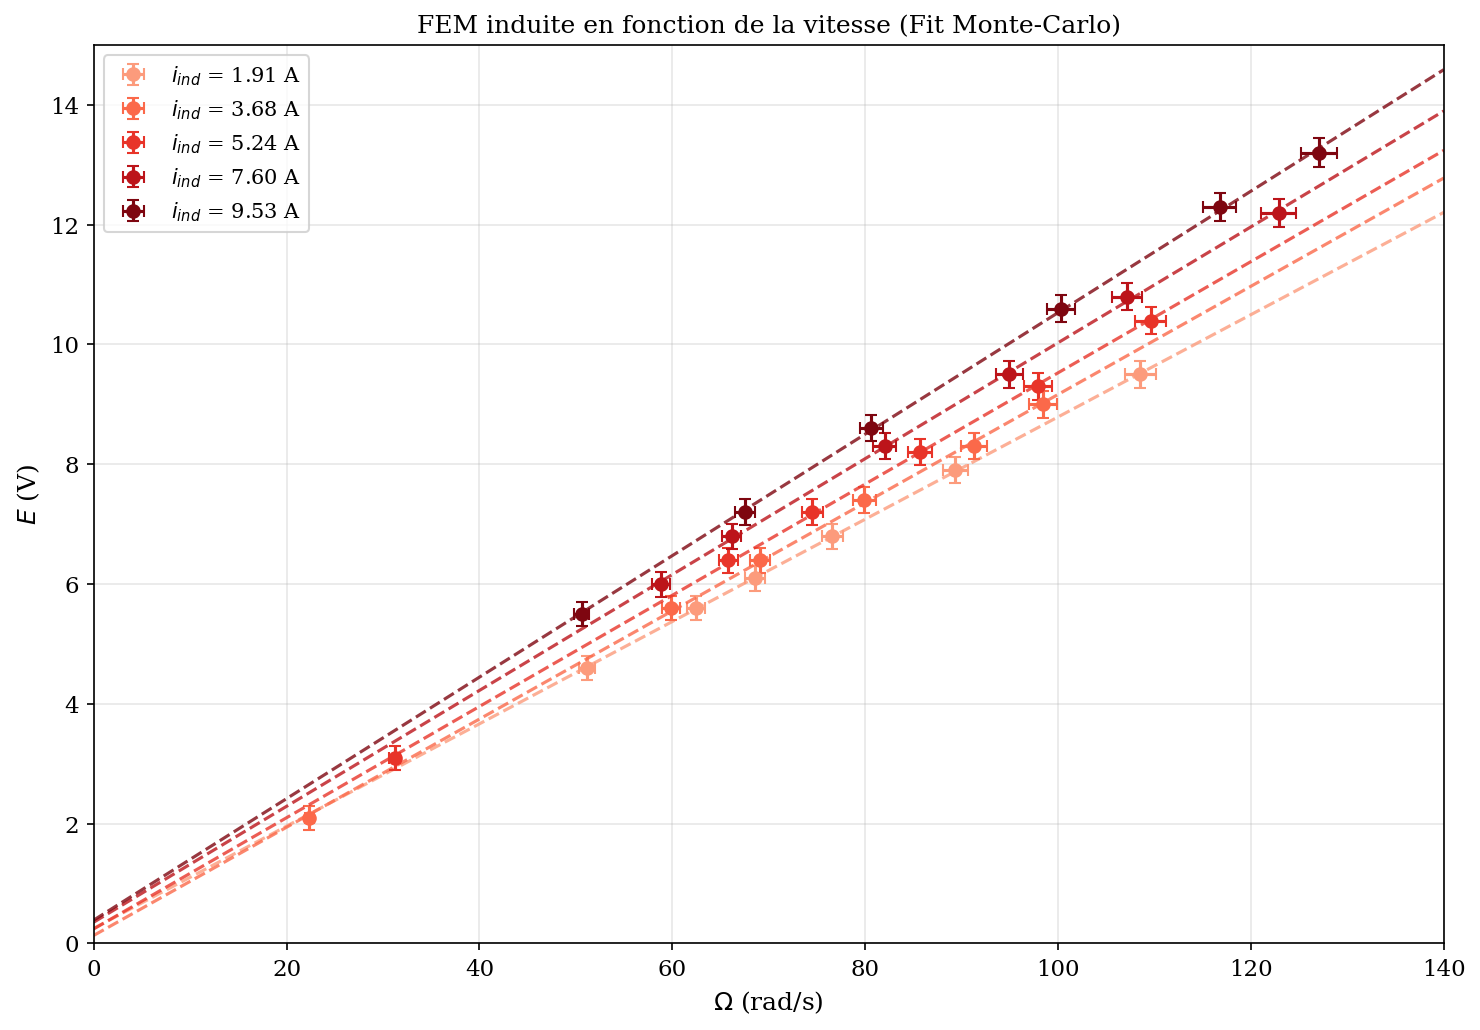

In [453]:
fig1, ax1 = plt.subplots(figsize=(10, 7))

colors = plt.cm.Reds(np.linspace(0.35, 0.95, 5))
markers = ['o', 'o', 'o', 'o', 'o']

# Dictionnaire pour les résultats (utile pour la figure 2)
mc_results = {}

# En-tête du tableau de comparaison
print("="*75)
print("RÉGRESSIONS E(Ω) PAR MONTE-CARLO")
print("="*75)
print(f"{'i (A)':<10} {'a (V·s/rad)':<15} {'u(a) MC':<15} {'b (V)':<12} {'u(b) MC':<12}")
print("-"*75)

for idx, (I_ind, measurements) in enumerate(data_fem.items()):
    
    # --- Extraction et conversion des données ---
    E_vals = np.array([m[0] for m in measurements], dtype=float)
    U_tachy_vals = np.array([m[1] for m in measurements], dtype=float)
    
    omega_vals = convert_to_omega_rad(U_tachy_vals)
    delta_omega = incertitude_omega(U_tachy_vals)
    delta_E = incertitude_tension(E_vals)
    
    # --- Monte-Carlo ---
    p_mean, p_std, p_list = monte_carlo_fit(modele_lineaire, 
                                            omega_vals, E_vals, 
                                            delta_omega, delta_E, 
                                            N=1000)
    
    a_mc, b_mc = p_mean
    ua_mc, ub_mc = p_std
    
    # Sauvegarde pour la suite
    mc_results[I_ind] = {
        'a': a_mc, 'ua': ua_mc,
        'b': b_mc, 'ub': ub_mc
    }
    
    # Affichage ligne par ligne
    print(f"{I_ind:<10.2f} {a_mc:<15.4f} {ua_mc:<15.4f} {b_mc:<12.3f} {ub_mc:<12.3f}")

    # --- Tracé ---
    ax1.errorbar(omega_vals, E_vals, xerr=delta_omega, yerr=delta_E,
                 fmt=markers[idx], color=colors[idx], capsize=3, markersize=6,
                 label=f'$i_{{ind}}$ = {I_ind:.2f} A')
    
    omega_fit = np.linspace(0, 140, 100)
    E_fit = modele_lineaire(omega_fit, a_mc, b_mc)
    ax1.plot(omega_fit, E_fit, '--', color=colors[idx], alpha=0.8, linewidth=1.5)

# Mise en forme
ax1.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax1.set_ylabel(r'$E$ (V)', fontsize=12)
ax1.set_title('FEM induite en fonction de la vitesse (Fit Monte-Carlo)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 140)
ax1.set_ylim(0, 15)

plt.tight_layout()
plt.savefig('figures/figure1_E_omega.png', dpi=300)
plt.show()

## 5. Tableau des paramètres de régression E(Ω)

Génération du tableau 3.4 du compte-rendu LaTeX avec arrondis corrects.

In [454]:
print("="*85)
print("TABLEAU 3.4 : Paramètres des régressions E = a·Ω + b (incertitudes à 95%)")
print("="*85)
print(f"{'i_ind (A)':<12} {'a (V·s/rad)':<16} {'u(a)_95%':<14} {'b (V)':<12} {'u(b)_95%':<12}")
print("-"*85)

for I_ind, res in mc_results.items():
    a = res['a']
    ua_95 = 2 * res['ua']  # 95% = 2 sigma
    b = res['b']
    ub_95 = 2 * res['ub']
    
    # Arrondis cohérents
    a_r, ua_r, dec_a = arrondi_valeur_incertitude(a, ua_95, N_CS)
    b_r, ub_r, dec_b = arrondi_valeur_incertitude(b, ub_95, N_CS)
    
    # Format dynamique
    a_str = format_dynamique(a_r, dec_a)
    ua_str = format_dynamique(ua_r, dec_a)
    b_str = format_dynamique(b_r, dec_b)
    ub_str = format_dynamique(ub_r, dec_b)
    
    print(f"{I_ind:<12.2f} {a_str:<16} {ua_str:<14} {b_str:<12} {ub_str:<12}")

# Calcul de la moyenne des ordonnées à l'origine
b_moyenne = np.mean([res['b'] for res in mc_results.values()])
print(f"\nOrdonnée à l'origine moyenne : b̄ = {b_moyenne:.2f} V")

TABLEAU 3.4 : Paramètres des régressions E = a·Ω + b (incertitudes à 95%)
i_ind (A)    a (V·s/rad)      u(a)_95%       b (V)        u(b)_95%    
-------------------------------------------------------------------------------------
1.91         0.0854           0.0063         0.25         0.47        
3.68         0.0903           0.0043         0.13         0.31        
5.24         0.0928           0.0044         0.24         0.34        
7.60         0.0967           0.0056         0.35         0.50        
9.53         0.1014           0.0046         0.39         0.41        

Ordonnée à l'origine moyenne : b̄ = 0.27 V


## 6. Figure 2 : $k(I_{inducteur})$ avec zone de confiance MC

On trace les pentes $k = a$ en fonction du courant inducteur.

Les barres d'erreur sur $k$ viennent directement du MC de l'étape précédente.
L'incertitude sur $I_{inducteur}$ est calculée à partir des spécifications de la pince F205.

Incertitudes sur le courant inducteur (pince F205) :
  I = 1.91 A  =>  ΔI = 0.11 A
  I = 3.68 A  =>  ΔI = 0.12 A
  I = 5.24 A  =>  ΔI = 0.14 A
  I = 7.60 A  =>  ΔI = 0.18 A
  I = 9.53 A  =>  ΔI = 0.22 A

RÉGRESSION k(i) : k = α·I + β (incertitudes à 95%)
α = (2.00 ± 0.51) × 10⁻³ (V·s/rad)/A
β = (8.21 ± 0.33) × 10⁻² V·s/rad


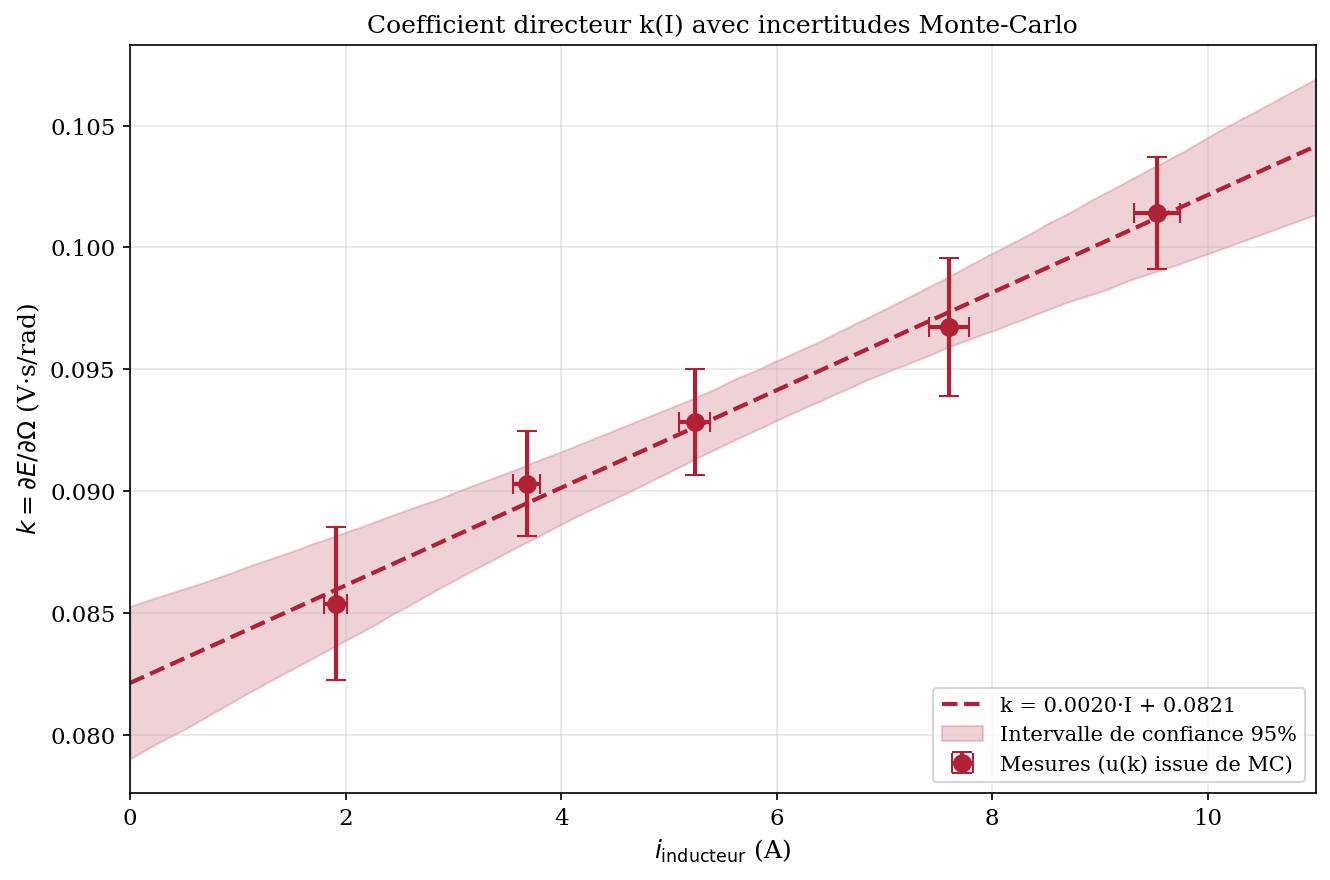

In [455]:
fig2, ax2 = plt.subplots(figsize=(9, 6))

# Récupération des données depuis mc_results
I_vals = np.array(list(mc_results.keys()), dtype=float)
k_vals = np.array([mc_results[I]['a'] for I in I_vals], dtype=float)
uk_vals = np.array([mc_results[I]['ua'] for I in I_vals], dtype=float)

# Incertitude sur I_inducteur : mesuré à la pince ampèremétrique F205
delta_I = incertitude_courant_pince(I_vals)

print("Incertitudes sur le courant inducteur (pince F205) :")
for I, dI in zip(I_vals, delta_I):
    dI_r, dI_dec = arrondi_incertitude(dI, N_CS)
    print(f"  I = {I:.2f} A  =>  ΔI = {format_dynamique(dI_r, dI_dec)} A")
print()

# --- Monte-Carlo sur k(I) ---
p_mean_k, p_std_k, p_list_k = monte_carlo_fit(modele_lineaire, 
                                              I_vals, k_vals, 
                                              delta_I, uk_vals, 
                                              N=1000)

alpha, beta = p_mean_k
u_alpha, u_beta = p_std_k

# Résultats avec arrondis corrects
alpha_95 = 2 * u_alpha
beta_95 = 2 * u_beta

print("="*70)
print("RÉGRESSION k(i) : k = α·I + β (incertitudes à 95%)")
print("="*70)

# Arrondi pour alpha (en notation scientifique ×10⁻³)
alpha_sci = alpha * 1e3
alpha_95_sci = alpha_95 * 1e3
alpha_r, ualpha_r, dec_alpha = arrondi_valeur_incertitude(alpha_sci, alpha_95_sci, N_CS)
print(f"α = ({format_dynamique(alpha_r, dec_alpha)} ± {format_dynamique(ualpha_r, dec_alpha)}) × 10⁻³ (V·s/rad)/A")

# Arrondi pour beta (en notation scientifique ×10⁻²)
beta_sci = beta * 1e2
beta_95_sci = beta_95 * 1e2
beta_r, ubeta_r, dec_beta = arrondi_valeur_incertitude(beta_sci, beta_95_sci, N_CS)
print(f"β = ({format_dynamique(beta_r, dec_beta)} ± {format_dynamique(ubeta_r, dec_beta)}) × 10⁻² V·s/rad")

# --- Tracé ---
ax2.errorbar(I_vals, k_vals, xerr=delta_I, yerr=uk_vals,
             fmt='o', color=ROUGE, capsize=5, markersize=8, linewidth=2,
             label='Mesures (u(k) issue de MC)', zorder=5)

I_fit = np.linspace(0, 11, 200)
k_fit = modele_lineaire(I_fit, alpha, beta)
ax2.plot(I_fit, k_fit, color=ROUGE, linestyle='--', linewidth=2,
         label=f"k = {alpha:.4f}·I + {beta:.4f}")

k_low, k_high = get_confidence_interval(modele_lineaire, I_fit, p_list_k, percentile=95)
ax2.fill_between(I_fit, k_low, k_high, color=ROUGE, alpha=0.2, label='Intervalle de confiance 95%')

# Mise en forme
ax2.set_xlabel(r'$i_{\mathrm{inducteur}}$ (A)', fontsize=12)
ax2.set_ylabel(r'$k = \partial E / \partial \Omega$ (V·s/rad)', fontsize=12)
ax2.set_title("Coefficient directeur k(I) avec incertitudes Monte-Carlo", fontsize=12)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)

plt.tight_layout()
plt.savefig('figures/figure2_k_I.png', dpi=300)
plt.show()

## 7. Rendement : Modèle polynomial avec Monte-Carlo

Ici on s'intéresse au rendement global du banc $\eta = P_{charge} / (P_{abs} + P_{inducteur})$.

La charge est assurée par un **banc de résistances de puissance** (charge résistive), réglable par paliers.

On modélise le rendement par un polynôme de degré 2 (forme en cloche observée expérimentalement).

In [456]:
# =============================================================================
# DONNÉES RENDEMENT
# =============================================================================

# Puissances mesurées pour différentes valeurs de la charge résistive (banc de résistances)
# Le pourcentage correspond à la somme des pourcentages de chaque réglage du banc de charge
#
# P_abs : pince ampèremétrique sur l'alimentation MCC
# P_charge : wattmètre sur la résistance de charge
# P_inducteur : wattmètre sur l'alimentation DC reliée à l'inducteur MS (valeur constante)

R_percent = np.array([5, 10, 15, 25, 30, 35, 40, 50, 75, 100], dtype=float)
P_abs = np.array([245.3, 302.3, 328, 335, 326, 318, 312, 303, 280, 266], dtype=float)
P_induc = 16.0  # Watts, constant (mesuré au wattmètre)
P_charge = np.array([80.4, 126, 141, 136, 125, 115, 107, 95, 69, 54], dtype=float)

# Incertitudes constructeur sur les puissances
delta_P_abs = incertitude_puissance_pince(P_abs)
delta_P_charge = incertitude_puissance_wattmetre(P_charge)
delta_P_induc = incertitude_puissance_wattmetre(P_induc)

dP_induc_r, dP_induc_dec = arrondi_incertitude(delta_P_induc, N_CS)
print(f"P_inducteur = {P_induc:.0f} W ± {format_dynamique(dP_induc_r, dP_induc_dec)} W (wattmètre)")
print()

# =============================================================================
# CALCUL DU RENDEMENT ET PROPAGATION
# =============================================================================

P_tot = P_abs + P_induc
delta_P_tot = np.sqrt(delta_P_abs**2 + delta_P_induc**2)  # somme quadratique

eta = P_charge / P_tot * 100  # en %

# Propagation pour l'incertitude sur eta
delta_eta_rel = np.sqrt((delta_P_charge / P_charge)**2 + (delta_P_tot / P_tot)**2)
delta_eta = eta * delta_eta_rel

# =============================================================================
# TABLEAU COMPLET POUR LE LATEX (Tableau 4.1)
# =============================================================================

print("="*105)
print("TABLEAU 4.1 : Mesures de puissance et rendement avec incertitudes constructeur")
print("="*105)
print(f"{'R (%)':<8} {'P_abs (W)':<12} {'ΔP_abs':<10} {'P_ch (W)':<12} {'ΔP_ch':<10} {'ΔP_tot':<10} {'η (%)':<10} {'Δη (%)':<10}")
print("-"*105)

for i in range(len(P_abs)):
    # Arrondis cohérents
    _, dPabs_r, dec_Pabs = arrondi_valeur_incertitude(P_abs[i], delta_P_abs[i], N_CS)
    _, dPch_r, dec_Pch = arrondi_valeur_incertitude(P_charge[i], delta_P_charge[i], N_CS)
    _, dPtot_r, dec_Ptot = arrondi_valeur_incertitude(P_tot[i], delta_P_tot[i], N_CS)
    eta_r, deta_r, dec_eta = arrondi_valeur_incertitude(eta[i], delta_eta[i], N_CS)
    
    # Format dynamique
    dPabs_str = format_dynamique(dPabs_r, dec_Pabs)
    dPch_str = format_dynamique(dPch_r, dec_Pch)
    dPtot_str = format_dynamique(dPtot_r, dec_Ptot)
    eta_str = format_dynamique(eta_r, dec_eta)
    deta_str = format_dynamique(deta_r, dec_eta)
    
    print(f"{R_percent[i]:<8.0f} {P_abs[i]:<12.1f} {dPabs_str:<10} {P_charge[i]:<12.1f} {dPch_str:<10} {dPtot_str:<10} {eta_str:<10} {deta_str:<10}")

print()

# =============================================================================
# RENDEMENT MAXIMUM EXPÉRIMENTAL (lu directement dans les données)
# =============================================================================

idx_max = np.argmax(eta)
eta_max_exp = eta[idx_max]
delta_eta_max_exp = delta_eta[idx_max]
P_charge_max_exp = P_charge[idx_max]
delta_P_charge_max_exp = delta_P_charge[idx_max]

# Arrondis
eta_max_r, deta_max_r, dec_eta_max = arrondi_valeur_incertitude(eta_max_exp, delta_eta_max_exp, N_CS)
Pmax_r, dPmax_r, dec_Pmax = arrondi_valeur_incertitude(P_charge_max_exp, delta_P_charge_max_exp, N_CS)

print("="*60)
print("RENDEMENT MAXIMUM EXPÉRIMENTAL (mesuré directement)")
print("="*60)
print(f"η_max = ({format_dynamique(eta_max_r, dec_eta_max)} ± {format_dynamique(deta_max_r, dec_eta_max)}) %")
print(f"à P_charge = ({format_dynamique(Pmax_r, dec_Pmax)} ± {format_dynamique(dPmax_r, dec_Pmax)}) W")
print()

# =============================================================================
# MONTE-CARLO SUR LE FIT POLYNOMIAL (pour la bande de confiance)
# =============================================================================

p_mean_eta, p_std_eta, p_list_eta = monte_carlo_fit(modele_poly2,
                                                    P_charge, eta,
                                                    delta_P_charge, delta_eta,
                                                    N=1000)

c2, c1, c0 = p_mean_eta
uc2, uc1, uc0 = p_std_eta

# Incertitudes à 95%
c2_95 = 2 * uc2
c1_95 = 2 * uc1
c0_95 = 2 * uc0

print("="*65)
print("MODÈLE POLYNOMIAL η(P) = c0 + c1·P + c2·P² (incertitudes à 95%)")
print("="*65)

# c0 (en %)
c0_r, uc0_r, dec_c0 = arrondi_valeur_incertitude(c0, c0_95, N_CS)
print(f"c0 = ({format_dynamique(c0_r, dec_c0)} ± {format_dynamique(uc0_r, dec_c0)}) %")

# c1 (en %/W)
c1_r, uc1_r, dec_c1 = arrondi_valeur_incertitude(c1, c1_95, N_CS)
print(f"c1 = ({format_dynamique(c1_r, dec_c1)} ± {format_dynamique(uc1_r, dec_c1)}) %/W")

# c2 (en notation scientifique ×10⁻⁴ %/W²)
c2_sci = c2 * 1e4
c2_95_sci = c2_95 * 1e4
c2_r, uc2_r, dec_c2 = arrondi_valeur_incertitude(c2_sci, c2_95_sci, N_CS)
print(f"c2 = ({format_dynamique(c2_r, dec_c2)} ± {format_dynamique(uc2_r, dec_c2)}) × 10⁻⁴ %/W²")

# Maximum théorique du modèle polynomial
if c2 < 0:
    P_opt = -c1 / (2 * c2)
    eta_opt = c0 + c1 * P_opt + c2 * P_opt**2
    print(f"\nMaximum théorique du modèle : η = {eta_opt:.1f}% à P = {P_opt:.0f} W")
    print("(non atteint expérimentalement)")

P_inducteur = 16 W ± 2.0 W (wattmètre)

TABLEAU 4.1 : Mesures de puissance et rendement avec incertitudes constructeur
R (%)    P_abs (W)    ΔP_abs     P_ch (W)     ΔP_ch      ΔP_tot     η (%)      Δη (%)    
---------------------------------------------------------------------------------------------------------
5        245.3        11         80.4         2.2        11         30.8       1.6       
10       302.3        12         126.0        2.4        12         39.6       1.7       
15       328.0        12         141.0        2.4        12         41.0       1.6       
25       335.0        12         136.0        2.4        12         38.7       1.5       
30       326.0        12         125.0        2.4        12         36.5       1.5       
35       318.0        12         115.0        2.3        12         34.4       1.4       
40       312.0        12         107.0        2.3        12         32.6       1.4       
50       303.0        12         95.0         2.2      

## 8. Figure 3 : Rendement

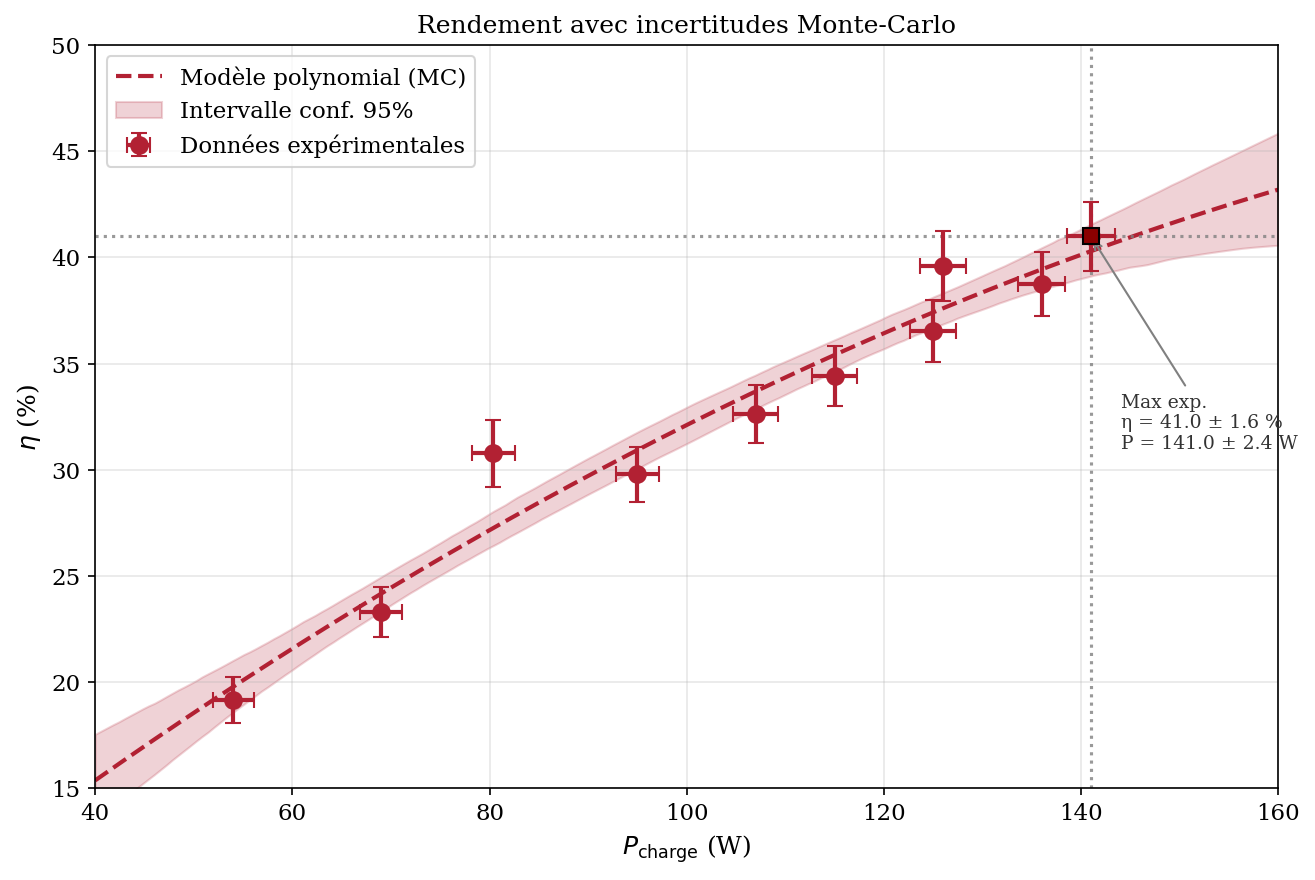

In [457]:
fig3, ax3 = plt.subplots(figsize=(9, 6))

# Points expérimentaux
ax3.errorbar(P_charge, eta, xerr=delta_P_charge, yerr=delta_eta,
             fmt='o', color=ROUGE, capsize=4, markersize=8, linewidth=2,
             label='Données expérimentales', zorder=5)

# Courbe du modèle
P_fit = np.linspace(40, 160, 200)
eta_fit = modele_poly2(P_fit, c2, c1, c0)
ax3.plot(P_fit, eta_fit, '--', color=ROUGE, linewidth=2, label='Modèle polynomial (MC)')

# Bande de confiance
eta_low, eta_high = get_confidence_interval(modele_poly2, P_fit, p_list_eta, percentile=95)
ax3.fill_between(P_fit, eta_low, eta_high, color=ROUGE, alpha=0.2, label='Intervalle conf. 95%')

# Marquer le maximum expérimental
ax3.axvline(x=P_charge_max_exp, color='gray', linestyle=':', alpha=0.8)
ax3.axhline(y=eta_max_exp, color='gray', linestyle=':', alpha=0.8)
ax3.plot(P_charge_max_exp, eta_max_exp, 's', color='darkred', markersize=8, 
         markeredgecolor='black', markeredgewidth=1, zorder=10)
ax3.annotate(f"Max exp.\nη = {format_val_inc(eta_max_exp, delta_eta_max_exp)} %\nP = {format_val_inc(P_charge_max_exp, delta_P_charge_max_exp)} W",
             xy=(P_charge_max_exp, eta_max_exp), xytext=(P_charge_max_exp+3, eta_max_exp-10),
             fontsize=9, color='#333',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1))

# Mise en forme
ax3.set_xlabel(r'$P_{\mathrm{charge}}$ (W)', fontsize=12)
ax3.set_ylabel(r'$\eta$ (%)', fontsize=12)
ax3.set_title('Rendement avec incertitudes Monte-Carlo', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(40, 160)
ax3.set_ylim(15, 50)

plt.tight_layout()
plt.savefig('figures/figure3_rendement.png', dpi=300)
plt.show()

## 9. Figure 4 : Rémanence ($I_{ind} = 0$)

Uniquement 3 points (fin de séance oblige) donc l'analyse reste qualitative.

In [458]:
# Données rémanence (i_inducteur = 0)
U_tachy_rem = np.array([48, 60, 73], dtype=float)
E_rem = np.array([5.6, 6.1, 6.5], dtype=float)

omega_rem = convert_to_omega_rad(U_tachy_rem)
delta_omega_rem = incertitude_omega(U_tachy_rem)
delta_E_rem = incertitude_tension(E_rem)

# =============================================================================
# TABLEAU POUR LE LATEX (Tableau 5.1)
# =============================================================================

print("="*85)
print("TABLEAU 5.1 : FEM résiduelle sans excitation, avec incertitudes constructeur")
print("="*85)
print(f"{'U_tachy (V)':<14} {'Ω (rad/s)':<14} {'ΔΩ (rad/s)':<14} {'E (V)':<10} {'ΔE (V)':<10}")
print("-"*85)

for i in range(len(U_tachy_rem)):
    omega_r, dO_r, dec_omega = arrondi_valeur_incertitude(omega_rem[i], delta_omega_rem[i], N_CS)
    _, dE_r, dec_E = arrondi_valeur_incertitude(E_rem[i], delta_E_rem[i], N_CS)
    
    print(f"{U_tachy_rem[i]:<14.0f} {format_dynamique(omega_r, dec_omega):<14} {format_dynamique(dO_r, dec_omega):<14} {E_rem[i]:<10.1f} {format_dynamique(dE_r, dec_E):<10}")

print()

# =============================================================================
# MONTE-CARLO
# =============================================================================

p_mean_rem, p_std_rem, p_list_rem = monte_carlo_fit(modele_lineaire, 
                                                    omega_rem, E_rem, 
                                                    delta_omega_rem, delta_E_rem, 
                                                    N=1000)
a_rem, b_rem = p_mean_rem
ua_rem, ub_rem = p_std_rem

# Incertitudes à 95%
a_rem_95 = 2 * ua_rem
b_rem_95 = 2 * ub_rem

print("="*65)
print("RÉMANENCE (i=0) : E = a·Ω + b (incertitudes à 95%)")
print("="*65)

# a en notation scientifique ×10⁻²
a_rem_sci = a_rem * 1e2
a_rem_95_sci = a_rem_95 * 1e2
a_rem_r, ua_rem_r, dec_a_rem = arrondi_valeur_incertitude(a_rem_sci, a_rem_95_sci, N_CS)
print(f"a = ({format_dynamique(a_rem_r, dec_a_rem)} ± {format_dynamique(ua_rem_r, dec_a_rem)}) × 10⁻² V·s/rad")

# b en V
b_rem_r, ub_rem_r, dec_b_rem = arrondi_valeur_incertitude(b_rem, b_rem_95, N_CS)
print(f"b = ({format_dynamique(b_rem_r, dec_b_rem)} ± {format_dynamique(ub_rem_r, dec_b_rem)}) V")

TABLEAU 5.1 : FEM résiduelle sans excitation, avec incertitudes constructeur
U_tachy (V)    Ω (rad/s)      ΔΩ (rad/s)     E (V)      ΔE (V)    
-------------------------------------------------------------------------------------
48             83.8           1.2            5.6        0.21      
60             104.7          1.5            6.1        0.21      
73             127.4          1.8            6.5        0.21      

RÉMANENCE (i=0) : E = a·Ω + b (incertitudes à 95%)
a = (2.06 ± 0.78) × 10⁻² V·s/rad
b = (3.89 ± 0.83) V


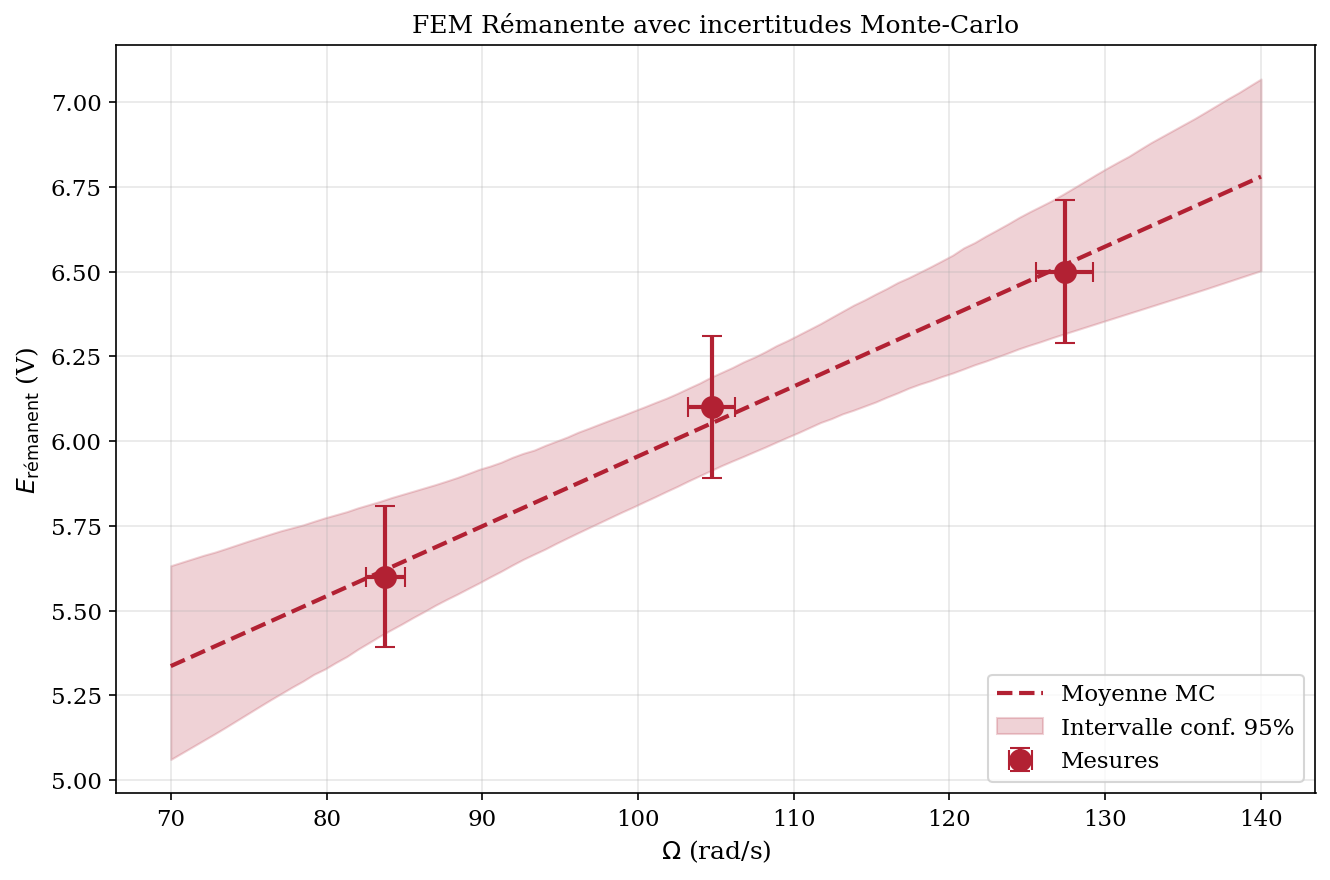

In [459]:
# --- Figure 4 ---
fig4, ax4 = plt.subplots(figsize=(9, 6))

ax4.errorbar(omega_rem, E_rem, xerr=delta_omega_rem, yerr=delta_E_rem,
             fmt='o', color=ROUGE, capsize=5, markersize=10, linewidth=2,
             label='Mesures', zorder=5)

omega_fit_rem = np.linspace(70, 140, 100)
E_fit_rem = modele_lineaire(omega_fit_rem, a_rem, b_rem)
ax4.plot(omega_fit_rem, E_fit_rem, '--', color=ROUGE, linewidth=2, label='Moyenne MC')

rem_low, rem_high = get_confidence_interval(modele_lineaire, omega_fit_rem, p_list_rem, percentile=95)
ax4.fill_between(omega_fit_rem, rem_low, rem_high, color=ROUGE, alpha=0.2, label='Intervalle conf. 95%')

ax4.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax4.set_ylabel(r'$E_{\mathrm{rémanent}}$ (V)', fontsize=12)
ax4.set_title("FEM Rémanente avec incertitudes Monte-Carlo", fontsize=12)
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/figure4_remanence.png', dpi=300)
plt.show()

## 10. Résumé Final

Récap de tous les résultats numériques pour le rapport, avec arrondis corrects.

In [460]:
print("="*85)
print("RÉSUMÉ FINAL AVEC INCERTITUDES MONTE-CARLO (95% = 2σ)")
print("="*85)

print("\n1) Coefficients k(i) pour E = a·Ω + b :")
print("-"*65)
for I, res in mc_results.items():
    a = res['a']
    ua_95 = 2 * res['ua']
    b = res['b']
    ub_95 = 2 * res['ub']
    a_r, ua_r, dec_a = arrondi_valeur_incertitude(a, ua_95, N_CS)
    b_r, ub_r, dec_b = arrondi_valeur_incertitude(b, ub_95, N_CS)
    print(f"   i = {I:.2f} A : a = {format_dynamique(a_r, dec_a)} ± {format_dynamique(ua_r, dec_a)} V·s/rad, "
          f"b = {format_dynamique(b_r, dec_b)} ± {format_dynamique(ub_r, dec_b)} V")

print("\n2) Relation k = α·I + β :")
print("-"*65)
print(f"   α = ({format_dynamique(alpha_r, dec_alpha)} ± {format_dynamique(ualpha_r, dec_alpha)}) × 10⁻³ (V·s/rad)/A")
print(f"   β = ({format_dynamique(beta_r, dec_beta)} ± {format_dynamique(ubeta_r, dec_beta)}) × 10⁻² V·s/rad")

print("\n3) Rendement maximum EXPÉRIMENTAL :")
print("-"*65)
print(f"   η_max = ({format_dynamique(eta_max_r, dec_eta_max)} ± {format_dynamique(deta_max_r, dec_eta_max)}) %")
print(f"   à P_charge = ({format_dynamique(Pmax_r, dec_Pmax)} ± {format_dynamique(dPmax_r, dec_Pmax)}) W")

print("\n4) Modèle polynomial η = c0 + c1·P + c2·P² :")
print("-"*65)
print(f"   c0 = ({format_dynamique(c0_r, dec_c0)} ± {format_dynamique(uc0_r, dec_c0)}) %")
print(f"   c1 = ({format_dynamique(c1_r, dec_c1)} ± {format_dynamique(uc1_r, dec_c1)}) %/W")
print(f"   c2 = ({format_dynamique(c2_r, dec_c2)} ± {format_dynamique(uc2_r, dec_c2)}) × 10⁻⁴ %/W²")

print("\n5) Rémanence (i_inducteur = 0) :")
print("-"*65)
print(f"   a = ({format_dynamique(a_rem_r, dec_a_rem)} ± {format_dynamique(ua_rem_r, dec_a_rem)}) × 10⁻² V·s/rad")
print(f"   b = ({format_dynamique(b_rem_r, dec_b_rem)} ± {format_dynamique(ub_rem_r, dec_b_rem)}) V")

print("\n" + "="*85)

RÉSUMÉ FINAL AVEC INCERTITUDES MONTE-CARLO (95% = 2σ)

1) Coefficients k(i) pour E = a·Ω + b :
-----------------------------------------------------------------
   i = 1.91 A : a = 0.0854 ± 0.0063 V·s/rad, b = 0.25 ± 0.47 V
   i = 3.68 A : a = 0.0903 ± 0.0043 V·s/rad, b = 0.13 ± 0.31 V
   i = 5.24 A : a = 0.0928 ± 0.0044 V·s/rad, b = 0.24 ± 0.34 V
   i = 7.60 A : a = 0.0967 ± 0.0056 V·s/rad, b = 0.35 ± 0.50 V
   i = 9.53 A : a = 0.1014 ± 0.0046 V·s/rad, b = 0.39 ± 0.41 V

2) Relation k = α·I + β :
-----------------------------------------------------------------
   α = (2.00 ± 0.51) × 10⁻³ (V·s/rad)/A
   β = (8.21 ± 0.33) × 10⁻² V·s/rad

3) Rendement maximum EXPÉRIMENTAL :
-----------------------------------------------------------------
   η_max = (41.0 ± 1.6) %
   à P_charge = (141.0 ± 2.4) W

4) Modèle polynomial η = c0 + c1·P + c2·P² :
-----------------------------------------------------------------
   c0 = (1.1 ± 7.0) %
   c1 = (0.39 ± 0.15) %/W
   c2 = (-7.8 ± 7.9) × 10⁻⁴ %/W²

